# Julia, MXNet and LSTMs

Recurrent neural networks (RNNs) are a sub-genre of artificial neural networks that can be used to classify or predict the next value in sequential data. For example, RNNs can be used to predict that the most probable next word in the phrase "The sky is" would be "blue". RNNs are also used for translating sentences between languages. These networks are often called  [sequence to sequence models](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf).

For this project, we will leverage RNNs to build a tool for predicting the next numerical value in a sequence. This tool can have various use cases. For example: 
* Predicting the next price of a stock based on historic movements. 
* Predicting the amount to order for a certain SKU (Store Keeping Unit) based on historic ordering and consumption patterns.
* Predicting spikes in network traffic. 

And many more.

### LSTM Architecture

We will be using a special RNN network that leverages a cell structure called Long short-term memory (LSTM). LSTMs were introduced into RNNs to facilitate back propagation. Prior to LSTMs, RNNs were practically unusable because the gradients would vanish for large sequence during the backprop phase.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png">

Source http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### Dataset

The data set we will be using is a sequence of 500 data points generated using a random walk. It is important to note that the more randomness in the data the harder it is to learn the underlying pattern generating the data. 

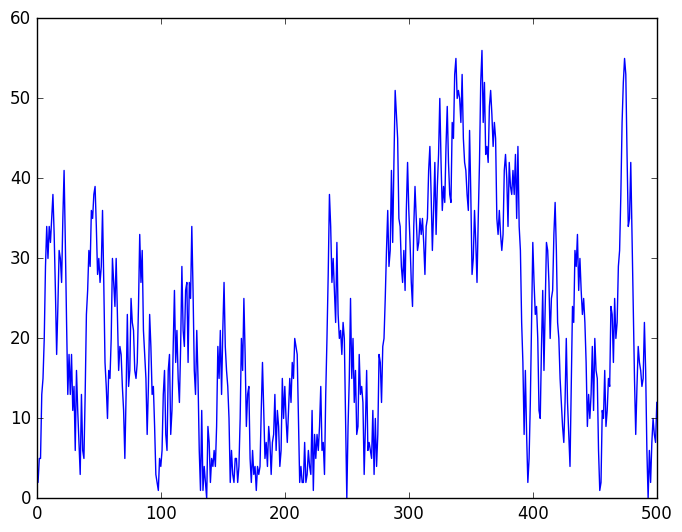

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3273fa810>

In [1]:
using PyPlot
raw = readstring("Output.txt")
sequence = split(raw);
plot(sequence)

### LSTM Implementation MXNet

Support for RNNs is being added to the majority of the Deep Neural Network frameworks (Keras, TensorFlow, Torch, Theano) but we decided to use MXNet and its Julia binding. It was chosen since the author wishes to learn more about MXNet and be able to compare it against the other frameworks in term of model creation verbosity. 

MXNet is a lesser known deep neural network that Amazon just threw its weight behind. Sadly, MXNet does not support LSTMs out of the box, but LSTMs can be constructed using MXNet's API. 

As we were researching LSTM implementations, we found a sample implementation of LSTMs on MXNet that can learn sentence sequences. We adapted that code to perform numeric regression by learning from the sequence of data mentioned in the previous section. (https://github.com/dmlc/MXNet.jl/tree/master/examples/char-lstm)

#### LSTM

This code section starts by defining an LSTM structure (`lstm_cell`) by leveraging MXNet's Neural Network API to recreate the 4 gates needed in each LSTM cell. 

A factory function (`LSTM`) is then used to allow the creation of a full LSTM network. 

In [2]:
Pkg.add("MXNet")
Pkg.add("StatsBase")
Pkg.add("Iterators")
Pkg.add("PyPlot")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of MXNet
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of StatsBase
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of Iterators
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [3]:
using MXNet

immutable LSTMState
  c :: mx.SymbolicNode
  h :: mx.SymbolicNode
end

immutable LSTMParam
  i2h_W :: mx.SymbolicNode
  h2h_W :: mx.SymbolicNode
  i2h_b :: mx.SymbolicNode
  h2h_b :: mx.SymbolicNode
end

function lstm_cell(data::mx.SymbolicNode, prev_state::LSTMState, param::LSTMParam;
                   num_hidden::Int=512, dropout::Real=0, name::Symbol=gensym())

  if dropout > 0
    data = mx.Dropout(data, p=dropout)
  end

  i2h = mx.FullyConnected(data=data, weight=param.i2h_W, bias=param.i2h_b,
                          num_hidden=4num_hidden, name=Symbol(name, "_i2h"))
  h2h = mx.FullyConnected(data=prev_state.h, weight=param.h2h_W, bias=param.h2h_b,
                          num_hidden=4num_hidden, name=Symbol(name, "_h2h"))

  gates = mx.SliceChannel(i2h + h2h, num_outputs=4, name=Symbol(name, "_gates"))

  in_gate     = mx.Activation(gates[1], act_type=:sigmoid)
  in_trans    = mx.Activation(gates[2], act_type=:tanh)
  forget_gate = mx.Activation(gates[3], act_type=:sigmoid)
  out_gate    = mx.Activation(gates[4], act_type=:sigmoid)

  next_c = (forget_gate .* prev_state.c) + (in_gate .* in_trans)
  next_h = out_gate .* mx.Activation(next_c, act_type=:tanh)

  return LSTMState(next_c, next_h)
end

function LSTM(n_layer::Int, seq_len::Int, dim_hidden::Int;
              dropout::Real=0, name::Symbol=gensym(), output_states::Bool=false)

  # placeholder nodes for all parameters
  embed_W = mx.Variable(Symbol(name, "_embed_weight"))
  pred_W  = mx.Variable(Symbol(name, "_pred_weight"))
  pred_b  = mx.Variable(Symbol(name, "_pred_bias"))

  layer_param_states = map(1:n_layer) do i
    param = LSTMParam(mx.Variable(Symbol(name, "_l$(i)_i2h_weight")),
                      mx.Variable(Symbol(name, "_l$(i)_h2h_weight")),
                      mx.Variable(Symbol(name, "_l$(i)_i2h_bias")),
                      mx.Variable(Symbol(name, "_l$(i)_h2h_bias")))
    state = LSTMState(mx.Variable(Symbol(name, "_l$(i)_init_c")),
                      mx.Variable(Symbol(name, "_l$(i)_init_h")))
    (param, state)
  end

  outputs = mx.SymbolicNode[]
  for t = 1:seq_len
    data   = mx.Variable(Symbol(name, "_data_$t"))
    label  = mx.Variable(Symbol(name, "_label_$t"))
    hidden = mx.FullyConnected(data=data, weight=embed_W, num_hidden=1,
                               no_bias=true, name=Symbol(name, "_embed_$t"))

    # stack LSTM cells
    for i = 1:n_layer
      l_param, l_state = layer_param_states[i]
      dp = i == 1 ? 0 : dropout # don't do dropout for data
      next_state = lstm_cell(hidden, l_state, l_param, num_hidden=dim_hidden, dropout=dp,
                             name=Symbol(name, "_lstm_$t"))

      hidden = next_state.h
      layer_param_states[i] = (l_param, next_state)
    end

    # prediction / decoder
    if dropout > 0
      hidden = mx.Dropout(hidden, p=dropout)
    end
    pred = mx.FullyConnected(data=hidden, weight=pred_W, bias=pred_b, num_hidden=n_class,
                             name=Symbol(name, "_pred_$t"))

    v = mx.LinearRegressionOutput(data = pred, label=label)
    push!(outputs, v)
  end

  # append block-gradient nodes to the final states
  for i = 1:n_layer
    l_param, l_state = layer_param_states[i]
    final_state = LSTMState(mx.BlockGrad(l_state.c, name=Symbol(name, "_l$(i)_last_c")),
                            mx.BlockGrad(l_state.h, name=Symbol(name, "_l$(i)_last_h")))
    layer_param_states[i] = (l_param, final_state)
  end

  # now group all outputs together
  if output_states
    outputs = outputs ∪ [x[2].c for x in layer_param_states] ∪
                        [x[2].h for x in layer_param_states]
  end
  return mx.Group(outputs...)
end


LSTM (generic function with 1 method)

#### Data Provider

MXNet offers AbstractDataProvider type that can be used to implement data providers. These data providers are used to either control the shape of the data fed into the model learning process, or to breakdown the training dataset into batches when said datasets do not fit in memory. For example, the famous ImageNet dataset that contains 1,000,000 images would not fit in memory during training, therefore if we wanted to train a convolutional neural network using MXNet and Julia, we would need to implement a data provider that would break the data set into batches that fit in memory. 

In this case, the data provider is being used to reshape the data input into sequences of data to be fed to the LSTM. 

In [4]:
# Simple data provider that load text
using Iterators
using MXNet

type SeqProvider <: mx.AbstractDataProvider
  list       :: Array{Int64,1}
  batch_size :: Int
  seq_len    :: Int

  prefix     :: Symbol
  n_layer    :: Int
  dim_hidden :: Int
end

function mx.get_batch_size(p :: SeqProvider)
  p.batch_size
end

function mx.provide_data(p :: SeqProvider)
  [(Symbol(p.prefix, "_data_$t"), (1, p.batch_size)) for t = 1:p.seq_len] ∪
  [(Symbol(p.prefix, "_l$(l)_init_c"), (p.dim_hidden, p.batch_size)) for l=1:p.n_layer] ∪
  [(Symbol(p.prefix, "_l$(l)_init_h"), (p.dim_hidden, p.batch_size)) for l=1:p.n_layer]
end

function mx.provide_label(p :: SeqProvider)
  [(Symbol(p.prefix, "_label_$t"), (p.batch_size,)) for t = 1:p.seq_len]
end

function mx.eachbatch(p :: SeqProvider)
  data_all  = [mx.zeros(shape) for (name, shape) in mx.provide_data(p)]
  label_all = [mx.zeros(shape) for (name, shape) in mx.provide_label(p)]

  data_jl = [copy(x) for x in data_all]
  label_jl= [copy(x) for x in label_all]

  batch = mx.DataBatch(data_all, label_all, p.batch_size)

  function _list_iter()
    list = p.list

    n_batch = floor(Int, length(list) / p.batch_size / p.seq_len)
    list = list[1:n_batch*p.batch_size*p.seq_len] # discard tailing
    idx_all = 1:length(list)

    for idx_batch in partition(idx_all, p.batch_size*p.seq_len)
      for (i, idx_seq) in enumerate(partition(idx_batch, p.seq_len))
        for (j, idx) in enumerate(idx_seq)
          c_this = list[idx]
          c_next = idx == length(list) ? -1 : list[idx+1]
          data_jl[j][1] = c_this
          label_jl[j][i] = c_next
        end
      end

      for i = 1:p.seq_len
        copy!(data_all[i], data_jl[i])
        copy!(label_all[i], label_jl[i])
      end

      produce(batch)
    end
  end

  return Task(_list_iter)
end

#### Network Hyperparameters 

This section lists the parameters that will define the network shape and its initial value. 

In [5]:
const DROPOUT       = 0
const BATCH_SIZE    = 32
const SEQ_LENGTH    = 5
const DIM_HIDDEN    = 256
const LSTM_N_LAYER  = 2
const N_EPOCH       = 100
const BASE_LR       = 0.01
const WEIGHT_DECAY  = 0.00001
const CLIP_GRADIENT = 1
const NAME          = :ptb
const DATA_TR_RATIO = 0.9
const BATCH_SIZE_SMP = 1
const SAMPLE_LENGTH = 5
const CKPOINT_PREFIX = joinpath(dirname(@__FILE__), "checkpoints/$NAME")

const USE_GPU = true
const N_GPU = 4;

#### Training and Validation

Now that we have our LSTM infrastructure implemented for number prediction, we can start feeding the data from the file and fitting the LSTM. The time needed to perform this process will depend on the hyperparameters mentioned above. It is important to note that to get adequate results, we will need to run the fitting process for a very large number of epochs. This is usually done using GPUs to expedite the learning process. 

In [6]:
n_class = 1

lstm = LSTM(LSTM_N_LAYER, SEQ_LENGTH, DIM_HIDDEN, dropout=DROPOUT, name=NAME)

sequence = map(x->parse(Int,x),sequence)
len_train = round(Int, length(sequence)*DATA_TR_RATIO)
seq_tr   = sequence[1:len_train]
seq_val  = sequence[len_train+1:end]

data_tr   = SeqProvider(seq_tr, BATCH_SIZE, SEQ_LENGTH, NAME, LSTM_N_LAYER, DIM_HIDDEN)
data_val  = SeqProvider(seq_val, BATCH_SIZE, SEQ_LENGTH, NAME, LSTM_N_LAYER, DIM_HIDDEN)

model = mx.FeedForward(lstm)

optimizer = mx.ADAM(lr=BASE_LR, weight_decay=WEIGHT_DECAY, grad_clip=CLIP_GRADIENT)

mx.fit(model, optimizer, data_tr, eval_data=data_val, n_epoch=N_EPOCH,
       initializer=mx.UniformInitializer(0.1),
       callbacks=[mx.speedometer(), mx.do_checkpoint(CKPOINT_PREFIX)], eval_metric=mx.MSE())

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 16 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001 ==========
INFO: ## Training summary
INFO:                MSE = 426.9540
INFO:               time = 1.1681 seconds
INFO: ## Validation summary
INFO:                MSE = NaN
INFO: Saved checkpoint to 'checkpoints/ptb-0001.params'
INFO: == Epoch 002 ==========
INFO: ## Training summary
INFO:                MSE = 338.6001
INFO:               time = 0.0947 seconds
INFO: ## Validation summary
INFO:                MSE = NaN
INFO: Saved checkpoint to 'checkpoints/ptb-0002.params'
INFO: == Epoch 003 ==========
INFO: ## Training summary
INFO:                MSE = 217.7243
INFO:               time = 0.1016 seconds
INFO: ## Validation summary
INFO:                MSE = NaN
INFO: Saved checkpoint to 'checkpoints/ptb-0003.params'
INFO: == Epoch 004 ==========
INFO: ## Training summary
INFO:               

#### Prediction and Sequence Generation

Now that we have a model trained, we can start predicting sequences. The quality of this prediction will be sensitive to randomness of the data used. 

In [7]:
using StatsBase
using MXNet

n_class = 1
starting_value = 3

# prepare data provider
jl_data = Pair[(Symbol(NAME, "_data_$t") => zeros(mx.MX_float, (1, BATCH_SIZE_SMP)))
               for t = 1:1]
jl_c    = Pair[(Symbol(NAME, "_l$(l)_init_c") => zeros(mx.MX_float, (DIM_HIDDEN, BATCH_SIZE_SMP)))
               for l = 1:LSTM_N_LAYER]
jl_h    = Pair[(Symbol(NAME, "_l$(l)_init_h") => zeros(mx.MX_float, (DIM_HIDDEN, BATCH_SIZE_SMP)))
               for l = 1:LSTM_N_LAYER]

# the first input in the sequence
jl_data_start = jl_data[1].second
jl_data_start[1] = starting_value

# define a LSTM with sequence length 1, also output states so that we could manually copy the states
# when sampling the next value
lstm  = LSTM(LSTM_N_LAYER, 1, DIM_HIDDEN, name=NAME, output_states=true)

model = mx.FeedForward(lstm)

# load parameters from traind LSTM, though the sequence length is different, since the weights are shared
# over time, this should be compatible.
model = mx.load_checkpoint(model, CKPOINT_PREFIX, N_EPOCH, allow_different_arch=true)

# prepare outputs
output_samples = zeros(Int, (SAMPLE_LENGTH, BATCH_SIZE_SMP))
output_samples[1, :] = starting_value

print("Initial Value = ")
println(starting_value)
# do prediction step by step
for t = 2:SAMPLE_LENGTH-1

    data    = mx.ArrayDataProvider(jl_data ∪ jl_c ∪ jl_h)
    preds   = mx.predict(model, data)

    # the first output is prediction
    outputs = preds[1]
    print("Sequence # = ")
    println(t)
    print("Prediction # = ")
    println(outputs)

  # copy the states over
    for l = 1:LSTM_N_LAYER
        copy!(jl_c[l][2], preds[1+l])
        copy!(jl_h[l][2], preds[1+LSTM_N_LAYER+l])
    end
end

Initial Value = 3


INFO: TempSpace: Total 0 MB allocated on CPU0


Sequence # = 2
Prediction # = Float32[12.3131]
Sequence # = 3
Prediction # = Float32[14.1906]
Sequence # = 4
Prediction # = Float32[16.0925]


INFO: TempSpace: Total 0 MB allocated on CPU0
INFO: TempSpace: Total 0 MB allocated on CPU0


### Conclusion

In this notebook, we have shown that it is possible to leverage Julia and MXNet to build an LSTM network. We have demonstrated how to ingest training data and then perform sequence learning and prediction.

Having previously built RNNs using both Keras and TensorFlow, one observation we had was that the model verbosity of MXNet was low compared to TensorFlow but similar to one built using Keras. 

Next steps is to train this implementation of LSTMs on various datasets that contain random degrees of randomness and then compare the amount of data needed to establish a dependable model. 